In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install face_recognition
!pip install git+https://github.com/rcmalli/keras-vggface.git
!pip install keras_vggface
!pip install keras_applications
!pip install keras==2.12

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566170 sha256=b321ba22a3770d087aea806d611f5cd61eff1f11884ce670096d2aac5a95420c
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models
  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-jknmixtg
  Running command git clone --filter=blob:none --quiet https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-jknmixtg
  Resolved https://github.com/rcmalli/keras-vggface.git to commit bee35376e76e35d00aeec503f2f242611a97b38a
  Preparing metadata (setup.py) ... done
  Created wheel for keras-vggface: filename=keras_vggface-0.6-py3-none-any.whl size=8294 sha256=4d2cf5cb9606ef904dc0466c9d5c1b45b91e239ea74d9e8f8724f88828a93e23
  Stored in 

In [3]:
import os
os.chdir('/content/drive/MyDrive/DeepLearning/Research/Face_Recognition') # Chỉ định nơi làm việc (terminal)


In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model , load_model
from keras.optimizers import Adam
from keras_vggface.vggface import VGGFace

import tensorflow as tf
import face_recognition
import cv2
import pickle
from PIL import Image
from keras_vggface import utils

import random
from imutils import paths
from sklearn.preprocessing import LabelEncoder

from datetime import datetime

In [ ]:
# VGGFace, không cần thiết phải chỉ định weights='imagenet' vì mô hình đã được huấn luyện trước trên tập dữ liệu riêng của nó.
base_model = VGGFace(include_top=False,model='senet50',input_shape=(224, 224, 3))
# base_model.summary()

myFCHead = base_model.output # (None, 1, 1, 2048) # lớp cuối của Conv VGGFace
myFCHead = GlobalAveragePooling2D()(myFCHead) # flatten # Cách 1 # làm phẳng
# myFCHead = Flatten(name='flatten')(myFCHead) # 1x1x2048 = 2048 # Cách 2
myFCHead = Dense(1024, activation='relu')(myFCHead)
myFCHead = Dense(1024, activation='relu')(myFCHead) # double 1024 chỉ để tăng số lượng tham số
myFCHead = Dense(512, activation='relu')(myFCHead)
myFCHead = Dense(128)(myFCHead) # output img is vector 128 dimensional
myModel = Model(inputs=base_model.input, outputs=myFCHead)
# myModel.summary()

# final layer with softmax activation

Compile model

In [ ]:
myModel.compile(optimizer='Adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

Load model với trọng số của VGG Face SENet50 và có Transfer learning : Fine tuning lại bằng dữ liệu ảnh của mình

In [14]:
vggSENet50 = load_model('./save_models/myVGGFace_SENet50_Transfer_Fine_Tuning_model-025.keras')
# Xóa lớp cuối cùng (lớp activation softmax)
vggSENet50 = Model(inputs=vggSENet50.input, outputs=vggSENet50.layers[-2].output)
# vggSENet50.summary() # đầu ra cuối cùng là lớp vector 128

In [11]:
def prepare_input_data (image_path) :
  count = 0
  list_image = []
  classnames = []
  target_size = (224 , 224)
  for (index_img, imagePath) in enumerate(image_path):
      name = imagePath.split("/")[-2]
      print(name)
      imagetest = face_recognition.load_image_file(imagePath)
      imagetest = cv2.cvtColor(imagetest, cv2.COLOR_BGR2RGB)
      # detect face
      faces = face_recognition.face_locations(imagetest)
      # if not exactly 1 face is detected, skip this photo
      if len(faces) == 0:
          continue
      count += 1
      print(count)
      for (y1, x2, y2, x1) in faces:
          # detected face region & resize the detected face to 224x224
          roi = imagetest[y1:y2, x1:x2]
          resized_image = cv2.resize(roi, target_size)
          # prepare the image for prediction
          x = tf.keras.preprocessing.image.img_to_array(resized_image)
          x = np.expand_dims(x, axis=0)
          x = utils.preprocess_input(x, version=1)
          list_image.append(x)
          classnames.append(name)
  # Chuyển danh sách các ảnh thành mảng numpy một chiều
  list_image = np.vstack(list_image)
  return list_image, classnames

#### Train

In [12]:
train_image_path = list(paths.list_images('./Dataset/train'))
random.shuffle(train_image_path)

In [13]:
train_list_image, train_classnames = prepare_input_data(train_image_path)

Phuc
1
Nghia
2
Quoc
3
Phuc
4
Quoc
5
Nghia
6
Lich
7
Can
8
Thai
9
Phuc
10
Thai
11
Manh
12
Cuong
13
Tung
14
Long
15
Quoc
16
Tu
17
Hung
18
Toan
19
Manh
20
Long
Tri
21
Can
22
Hung
23
Thuan
24
Thuan
25
Manh
26
Lich
27
Toan
28
Tu
29
Phuc
30
Tri
31
Long
32
Tung
33
Lich
34
Hung
35
Long
Thuan
36
Can
37
Quoc
38
Manh
39
Can
40
Huy
41
Thuan
42
Toan
43
Tri
44
Phuc
45
Phuc
46
Cuong
47
Quoc
48
Nghia
49
Thuan
50
Huy
Thuan
51
Huy
52
Long
53
Tu
54
Toan
55
Can
56
Manh
57
Tri
58
Tu
59
Long
60
Hung
61
Thai
62
Tu
63
Phuc
64
Thuan
65
Tri
66
Manh
67
Cuong
68
Huy
69
Huy
70
Lich
71
Dat
72
Cuong
73
Quoc
74
Hung
75
Phuc
76
Quoc
Tu
77
Thai
78
Long
79
Huy
80
Nghia
81
Phuc
82
Quoc
83
Long
84
Cuong
85
Toan
86
Thuan
87
Tung
88
Quoc
Tu
89
Nghia
90
Tung
91
Cuong
92
Cuong
93
Tri
94
Can
95
Can
96
Thai
97
Manh
98
Nghia
99
Thai
100
Huy
101
Manh
102
Tu
103
Toan
104
Thuan
105
Hung
106
Manh
107
Long
108
Tung
109
Thai
110
Can
111
Phuc
112
Nghia
113
Long
114
Tri
115
Huy
116
Cuong
117
Lich
118
Thai
119
Long
120
Tri
121
Tung
122
Ca

Trích xuất vector đặc trưng

In [15]:
print(train_list_image.shape)
train_features = vggSENet50.predict(train_list_image) # tensor Đặc trưng ảnh
print(train_features.shape)

(146, 224, 224, 3)
5/5 [==============================] - 8s 515ms/step
(146, 128)


Lưu dữ liệu vào .csv (Tạo trước folder và 2 file này)

In [16]:
df = pd.DataFrame(train_features)
dfname = pd.DataFrame(train_classnames)
df.to_csv("./V2_CSVfile/train_face_features.csv", index=False)
dfname.to_csv("./V2_CSVfile/train_face_classnames.csv", index=False)

#### Test

In [17]:
test_image_path = list(paths.list_images('./Dataset/test_unknow'))
random.shuffle(test_image_path)

In [18]:
test_list_image, test_classnames = prepare_input_data(test_image_path)

Can
1
Tri
2
Can
3
Can
4
Can
5
Thai
6
Tu
7
Can
8
Tu
9
Long
10
UNKNOW
11
Cuong
12
Long
13
Thai
14
UNKNOW
15
Phuc
16
Long
17
Thuan
18
UNKNOW
19
Thuan
20
Tu
21
Can
22
Dat
23
Thai
24
Thai
25
Phuc
26
Tu
27
Can
28
Phuc
29
Thuan
30
Dat
31
Thuan
32
Thai
33
Long
34
Tri
35
Can
36
Thuan
37
Thuan
38
Tu
39
Thuan
40
Thuan
41
UNKNOW
42
Can
43
Thai
44
Thai
45
UNKNOW
46
Tri
47
Cuong
48
Thuan
49
Phuc
50
Phuc
51
Cuong
52
Phuc
53
Phuc
54
Can
55
Phuc
56
Tu
57
Can
58
Tri
59
Tri
60
UNKNOW
61
Long
62
Can
63
Thuan
64
UNKNOW
65
Long
66
Cuong
67
Phuc
68
Dat
69
Tri
70
Phuc
Long
71
Thai
72
Tu
73
Thuan
Thuan
74
Can
75
Phuc
76
Phuc
77
UNKNOW
78
UNKNOW
79


In [19]:
test_unknow_features = vggSENet50.predict(test_list_image)

3/3 [==============================] - 2s 1s/step


In [20]:
df = pd.DataFrame(test_unknow_features)
dfname = pd.DataFrame(test_classnames)
df.to_csv("./V2_CSVfile/test_unknow_face_features.csv", index=False)
dfname.to_csv("./V2_CSVfile/test_unknow_face_classnames.csv", index=False)

In [21]:
train_features = pd.read_csv('./V2_CSVfile/train_face_features.csv')
train_classnames = pd.read_csv('./V2_CSVfile/train_face_classnames.csv')
print(train_features.shape)
print(train_classnames.shape)

test_features = pd.read_csv('./V2_CSVfile/test_unknow_face_features.csv')
test_classnames = pd.read_csv('./V2_CSVfile/test_unknow_face_classnames.csv')
print(test_features.shape)
print(test_classnames.shape)

(146, 128)
(146, 1)
(85, 128)
(85, 1)


In [22]:
# Chuyển dữ liệu từ DataFrame sang numpy array
train_features = np.array(train_features)
train_classnames = np.array(train_classnames).reshape(-1)

test_features = np.array(test_features)
test_classnames = np.array(test_classnames).reshape(-1)

In [23]:
# Hàm dự đoán nhãn của các vector trong tập test dựa trên tập train
def predict_labels(train_features, train_classnames, test_features, threshold=0.6):
    predictions = []
    for test_feature in test_features:
        face_distances = face_recognition.face_distance(train_features, test_feature)
        min_distance_index = np.argmin(face_distances)
        min_distance = face_distances[min_distance_index]
        if min_distance <= threshold:
            prediction = train_classnames[min_distance_index]
        else:
            prediction = "UNKNOW"
        predictions.append(prediction)
    return predictions

Khảo sát ngưỡng

Threshold: 1 , Accuracy: 12.941176470588237 %
Threshold: 2 , Accuracy: 18.823529411764707 %
Threshold: 3 , Accuracy: 27.058823529411764 %
Threshold: 4 , Accuracy: 30.58823529411765 %
Threshold: 5 , Accuracy: 32.94117647058823 %
Threshold: 6 , Accuracy: 30.58823529411765 %
Threshold: 7 , Accuracy: 31.76470588235294 %
Threshold: 8 , Accuracy: 31.76470588235294 %
Threshold: 9 , Accuracy: 31.76470588235294 %
Threshold: 10 , Accuracy: 31.76470588235294 %
Threshold: 11 , Accuracy: 32.94117647058823 %
Threshold: 12 , Accuracy: 30.58823529411765 %
Threshold: 13 , Accuracy: 30.58823529411765 %
Threshold: 14 , Accuracy: 30.58823529411765 %
Threshold: 15 , Accuracy: 30.58823529411765 %
Threshold: 16 , Accuracy: 30.58823529411765 %
Threshold: 17 , Accuracy: 30.58823529411765 %
Threshold: 18 , Accuracy: 30.58823529411765 %
Threshold: 19 , Accuracy: 30.58823529411765 %
Threshold: 20 , Accuracy: 30.58823529411765 %
Threshold: 21 , Accuracy: 29.411764705882355 %
Threshold: 22 , Accuracy: 29.4117647058

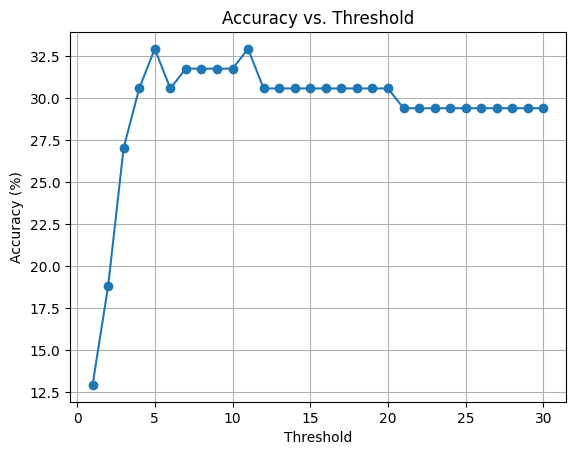

In [24]:
# Khởi tạo mảng để lưu độ chính xác của từng ngưỡng
accuracies = []
for threshold in range(1, 31):  # Chạy từ 1 đến 30
    # Dự đoán nhãn của các vector trong tập test
    predicted_labels = predict_labels(train_features, train_classnames, test_features, threshold)
    # Tính độ chính xác và lưu vào mảng accuracies
    accuracy = np.mean(predicted_labels == test_classnames) * 100
    accuracies.append(accuracy)
    # In kết quả
    print("Threshold:", threshold, ", Accuracy:", accuracy, "%")
# Vẽ đồ thị
plt.plot(range(1, 31), accuracies, marker='o')
plt.title('Accuracy vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.show()


In [25]:
# Ngưỡng cho độ chính xác cao nhấy là 15
# Dự đoán nhãn của các vector trong tập test
threshold = 15  # Ngưỡng khoảng cách
predicted_labels = predict_labels(train_features, train_classnames, test_features, threshold)

# Tính độ chính xác
accuracy = np.mean(predicted_labels == test_classnames) * 100
print("Accuracy:", accuracy, "%")

Accuracy: 30.58823529411765 %


#### Dự đoán thực tế

In [26]:
real_test_image_path = list(paths.list_images('./Dataset/real_test'))
print(real_test_image_path)
real_test_list_image, real_test_classnames = prepare_input_data(real_test_image_path)
real_test_features = vggSENet50.predict(real_test_list_image)

['./Dataset/real_test/Manh (3).jpg', './Dataset/real_test/Manh (1).jpg', './Dataset/real_test/Manh (2).jpg', './Dataset/real_test/4 Face.jpg']
real_test
1
real_test
2
real_test
3
real_test
4
1/1 [==============================] - 1s 1s/step


In [27]:
predicted_labels = predict_labels(train_features, train_classnames, real_test_features, threshold = 15)

In [28]:
print(predicted_labels)

['Tung', 'Phuc', 'Manh', 'UNKNOW', 'UNKNOW', 'Phuc', 'UNKNOW']
